In [75]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import diffusion_pde as dpde
from diffusion_pde.pdes import generate_heat
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from tqdm import tqdm, trange

from pathlib import Path    

In [87]:
data_name = "logt"
model_path = Path().cwd().parent / "pretrained_models" / f"heat_{data_name}.pth"
data_path = Path().cwd().parent / "data" / f"heat_{data_name}.hdf5"
model_path.exists(), data_path.exists()

(True, True)

In [88]:
chs = [2, 32, 64, 128, 256]
noise_ch = 32
label_ch = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = dpde.models.Unet(chs=chs, label_ch=label_ch, noise_ch=noise_ch)
edm = dpde.models.EDMWrapper(unet)

edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [89]:
with h5py.File(data_path, "r") as f:
    attrs = dict(f.attrs)
    data_A = f["test/A"][:]  # (N, 1, S, S)
    data_U = f["test/U"][:]  # (N, 1, S, S, steps+1)
    data_labels = f["test/labels"][:]  # (N,)
    t_steps = f["t_steps"][:]  # (steps+1,)
print("A shape: ", data_A.shape)  # (N, 1, S, S)
print("U shape: ", data_U.shape)  # (N, 1, S, S, steps+1)
print("Labels shape: ", data_labels.shape)  # (N,)
print("t_steps shape: ", t_steps.shape)  # (steps+1,)

[print(k, ":", v) for k, v in attrs.items()];

A shape:  (200, 1, 64, 64)
U shape:  (200, 1, 64, 64, 65)
Labels shape:  (200, 1)
t_steps shape:  (65,)
Lx : 1.0
Ly : 1.0
S : 64
T : 0.5
alpha_logrange : [-2.  0.]
description : 2D heat equation with linear Dirichlet BCs, data generated with sine-pseudospectral method with lifting. Time steps in log-scale.
dx : 0.015873015873015872
name : heat_logt
num_test : 200
num_train : 800
steps : 64


In [90]:
T = attrs["T"]
S = attrs["S"]
Lx = attrs["Lx"]
Ly = attrs["Ly"]

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [93]:
NUM_TEST_SAMPLES = 50
T_STEPS = 100
SEED = 42

#spacing_fn = lambda start, stop, num_steps: torch.logspace(math.log10(start + 1e-4), math.log10(stop), num_steps)
spacing_fn = torch.linspace

t_steps = spacing_fn(0, T, T_STEPS + 1)
dt = t_steps[1:] - t_steps[:-1]

In [94]:
Us, As, t_steps, labels = generate_heat(
    N=NUM_TEST_SAMPLES,
    B=50,
    S=S,
    steps=T_STEPS,
    dt=dt,
    Lx=Lx,
    Ly=Ly,
    device="cuda",
    ic_seed=SEED
)

In [95]:
Us = torch.tensor(Us) if not isinstance(Us, torch.Tensor) else Us
As = torch.tensor(As) if not isinstance(As, torch.Tensor) else As
labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
t_steps = torch.tensor(t_steps) if not isinstance(t_steps, torch.Tensor) else t_steps

In [96]:
mask_a = torch.ones_like(As[0])
mask_u = torch.zeros_like(Us[0, ..., 0])
mask_u[0, :] = 1
mask_u[-1, :] = 1
mask_u[:, 0] = 1
mask_u[:, -1] = 1

dx = Lx / S
ch_a = 1

sample_shape = (32, 2, 64, 64)

zeta_a = 50.0
zeta_u = 5.0
zeta_pde = 1.0
 
num_steps = 40

In [102]:
errors = np.zeros((NUM_TEST_SAMPLES, t_steps.shape[0], sample_shape[0]))

for i in range(2):
    print(f"Validating sample {i+1}/{NUM_TEST_SAMPLES}")
    alpha = float(data_labels[i, 0])
    for j in trange(t_steps.shape[0]):
        obs_a = As[i]
        obs_u = Us[i, ..., j]
        obs = torch.cat([obs_a, obs_u], dim=0)
        loss_fn_kwargs = {
            "obs_a": obs_a,
            "obs_u": obs_u,
            "mask_a": mask_a,
            "mask_u": mask_u,
            "dx": dx,
            "ch_a": ch_a,
            "alpha": alpha,
        }
        t_labels = torch.full((sample_shape[0], 1), t_steps[j])
        a_labels = torch.full((sample_shape[0], 1), alpha)
        labels = torch.cat([t_labels, a_labels], dim=1).to(device)

        samples, _ = dpde.sampling.edm_sampler(
            net=edm,
            device=device,
            sample_shape=sample_shape,
            loss_fn=dpde.sampling.heat_loss,
            loss_fn_kwargs=loss_fn_kwargs,
            labels=labels,
            zeta_a=zeta_a,
            zeta_u=zeta_u,
            zeta_pde=zeta_pde,
            num_steps=num_steps,
        )

        errors[i, j, :] = torch.mean((torch.tensor(samples) - obs.unsqueeze(0)) ** 2, dim=(1, 2, 3)).detach().cpu().numpy()

Validating sample 1/50


100%|██████████| 101/101 [00:40<00:00,  2.51it/s]


Validating sample 2/50


100%|██████████| 101/101 [00:36<00:00,  2.75it/s]


In [108]:
mean_error = np.sqrt(errors).mean(axis=0)

In [109]:
mean_error.shape

(101, 32)

In [110]:
mu = mean_error.mean(axis=1)
std = mean_error.std(axis=1)

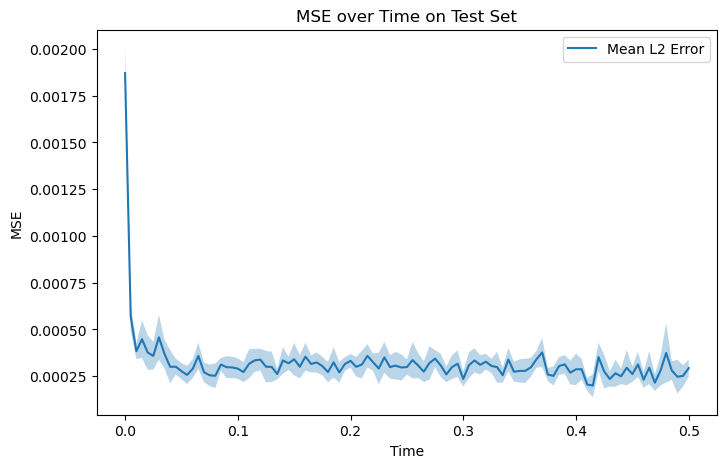

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_steps.numpy(), mu, label="Mean L2 Error")
ax.fill_between(
    t_steps.numpy(),
    mu - std,
    mu + std,
    alpha=0.3,
)
ax.set_xlabel("Time")
ax.set_ylabel("RMSE")
ax.set_title("RMSE over Time on Test Set")
ax.legend()
plt.show()